# Environmental Similarity Analysis: Google Earth vs ENVO Embeddings

This notebook compares the cosine similarity between Google Earth Engine satellite embeddings and ENVO ontology embeddings for environmental samples.


## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast
import random
from itertools import combinations
from scipy.stats import pearsonr, spearmanr

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Load the data with both embeddings
df = pd.read_csv('data/date_and_latlon_samples_extended_ONLY_ENVO_SAMPLE_100_with_both_embeddings.tsv', 
                 sep='\t', low_memory=False)

print(f"Total rows loaded: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Check for rows with both embeddings
has_both = df['google_earth_embeddings'].notna() & df['envo_embeddings'].notna()
df_both = df[has_both].copy()

print(f"\nRows with both embeddings: {len(df_both)}")
print(f"Success rate: {len(df_both)/len(df)*100:.1f}%")

Total rows loaded: 99
Columns: ['genome_id', 'ncbi_biosample_accession_id', 'ncbi_lat_lon', 'lat_lon', 'date', 'ncbi_bioproject', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'collection_date', 'geographic_location_harmonized', 'host_harmonized', 'isolation_source_harmonized', 'project_name', 'env_broad_med_local', 'misc_attributes', 'google_earth_embeddings', 'envo_embeddings']

Rows with both embeddings: 87
Success rate: 87.9%


## Embedding Processing Functions

In [3]:
def parse_embedding(embedding_str):
    """Parse embedding string to numpy array."""
    try:
        # Handle string representation of list
        if isinstance(embedding_str, str):
            embedding_list = ast.literal_eval(embedding_str)
        else:
            embedding_list = embedding_str
        return np.array(embedding_list, dtype=np.float32)
    except Exception as e:
        print(f"Error parsing embedding: {e}")
        return None

def compute_cosine_similarity(emb1, emb2):
    """Compute cosine similarity between two embeddings."""
    if emb1 is None or emb2 is None:
        return np.nan
    
    # Reshape for sklearn
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)
    
    return cosine_similarity(emb1, emb2)[0, 0]

In [4]:
# Parse embeddings for rows with both types
print("Parsing Google Earth embeddings...")
df_both['ge_embedding'] = df_both['google_earth_embeddings'].apply(parse_embedding)

print("Parsing ENVO embeddings...")
df_both['envo_embedding'] = df_both['envo_embeddings'].apply(parse_embedding)

# Filter out any rows where parsing failed
valid_embeddings = (df_both['ge_embedding'].notna()) & (df_both['envo_embedding'].notna())
df_clean = df_both[valid_embeddings].copy()

print(f"\nRows with valid parsed embeddings: {len(df_clean)}")

# Check embedding dimensions
if len(df_clean) > 0:
    ge_dim = len(df_clean.iloc[0]['ge_embedding'])
    envo_dim = len(df_clean.iloc[0]['envo_embedding'])
    print(f"Google Earth embedding dimension: {ge_dim}")
    print(f"ENVO embedding dimension: {envo_dim}")

Parsing Google Earth embeddings...
Parsing ENVO embeddings...

Rows with valid parsed embeddings: 87
Google Earth embedding dimension: 64
ENVO embedding dimension: 1536


## Generate Random Pairs and Calculate Similarities

In [5]:
# Generate 1000 random pairs of genome_ids
n_pairs = 1000
genome_ids = df_clean['genome_id'].tolist()
n_genomes = len(genome_ids)

print(f"Generating {n_pairs} random pairs from {n_genomes} genomes...")

# Generate random pairs (with replacement to get exactly 1000 pairs)
pairs = []
for i in range(n_pairs):
    idx1, idx2 = random.sample(range(n_genomes), 2)
    pairs.append((idx1, idx2))

print(f"Generated {len(pairs)} pairs")

Generating 1000 random pairs from 87 genomes...
Generated 1000 pairs


In [6]:
# Calculate cosine similarities for all pairs
ge_similarities = []
envo_similarities = []
pair_info = []

print("Computing cosine similarities...")

for i, (idx1, idx2) in enumerate(pairs):
    if i % 100 == 0:
        print(f"Processing pair {i+1}/{len(pairs)}")
    
    row1 = df_clean.iloc[idx1]
    row2 = df_clean.iloc[idx2]
    
    # Calculate Google Earth similarity
    ge_sim = compute_cosine_similarity(row1['ge_embedding'], row2['ge_embedding'])
    
    # Calculate ENVO similarity
    envo_sim = compute_cosine_similarity(row1['envo_embedding'], row2['envo_embedding'])
    
    if not (np.isnan(ge_sim) or np.isnan(envo_sim)):
        ge_similarities.append(ge_sim)
        envo_similarities.append(envo_sim)
        pair_info.append({
            'genome_id_1': row1['genome_id'],
            'genome_id_2': row2['genome_id'],
            'ge_similarity': ge_sim,
            'envo_similarity': envo_sim
        })

print(f"\nComputed similarities for {len(ge_similarities)} valid pairs")
print(f"Google Earth similarity range: [{min(ge_similarities):.3f}, {max(ge_similarities):.3f}]")
print(f"ENVO similarity range: [{min(envo_similarities):.3f}, {max(envo_similarities):.3f}]")

Computing cosine similarities...
Processing pair 1/1000
Processing pair 101/1000
Processing pair 201/1000
Processing pair 301/1000
Processing pair 401/1000
Processing pair 501/1000
Processing pair 601/1000
Processing pair 701/1000
Processing pair 801/1000
Processing pair 901/1000

Computed similarities for 1000 valid pairs
Google Earth similarity range: [-0.172, 1.000]
ENVO similarity range: [0.105, 1.000]


## Statistical Analysis

In [7]:
# Calculate correlations
pearson_corr, pearson_p = pearsonr(ge_similarities, envo_similarities)
spearman_corr, spearman_p = spearmanr(ge_similarities, envo_similarities)

print("=== CORRELATION ANALYSIS ===")
print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.2e})")

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print("Google Earth Embeddings:")
print(f"  Mean: {np.mean(ge_similarities):.3f}")
print(f"  Std: {np.std(ge_similarities):.3f}")
print(f"  Median: {np.median(ge_similarities):.3f}")

print("\nENVO Embeddings:")
print(f"  Mean: {np.mean(envo_similarities):.3f}")
print(f"  Std: {np.std(envo_similarities):.3f}")
print(f"  Median: {np.median(envo_similarities):.3f}")

=== CORRELATION ANALYSIS ===
Pearson correlation: 0.433 (p-value: 4.99e-47)
Spearman correlation: 0.212 (p-value: 1.18e-11)

=== SUMMARY STATISTICS ===
Google Earth Embeddings:
  Mean: 0.261
  Std: 0.293
  Median: 0.136

ENVO Embeddings:
  Mean: 0.421
  Std: 0.219
  Median: 0.366


## Visualization

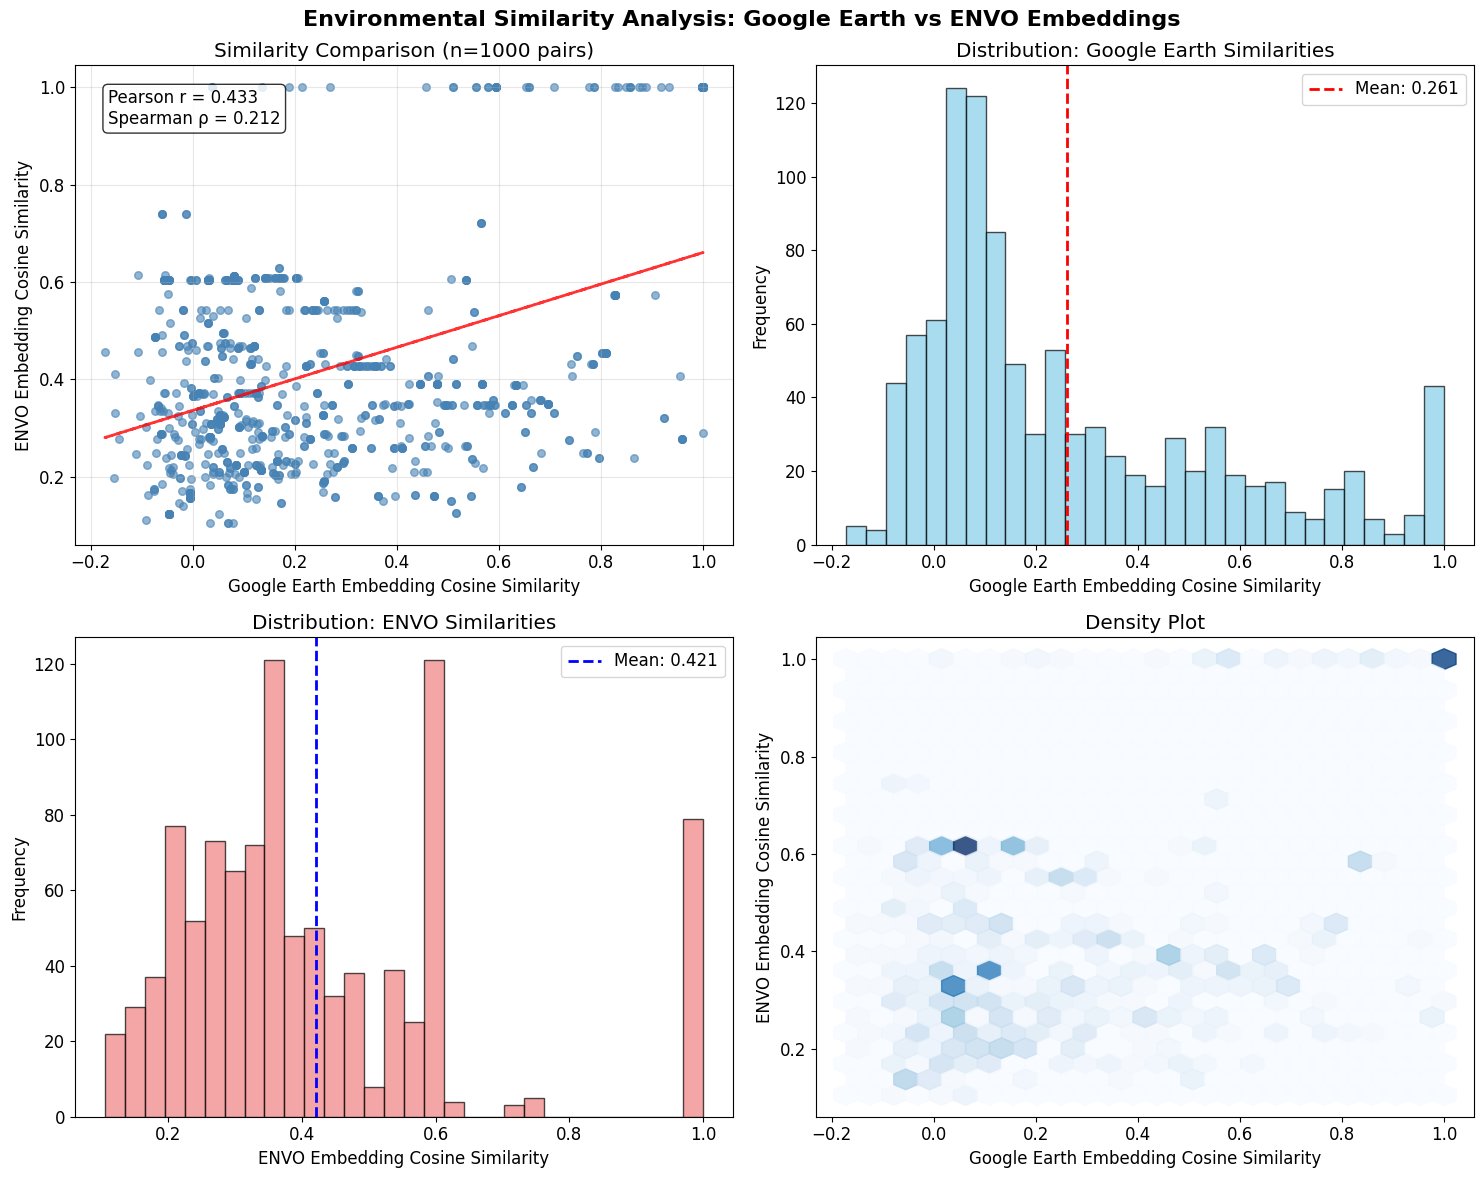

In [8]:
# Create the main scatter plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Environmental Similarity Analysis: Google Earth vs ENVO Embeddings', fontsize=16, fontweight='bold')

# Main scatter plot
ax1 = axes[0, 0]
scatter = ax1.scatter(ge_similarities, envo_similarities, alpha=0.6, s=30, color='steelblue')
ax1.set_xlabel('Google Earth Embedding Cosine Similarity')
ax1.set_ylabel('ENVO Embedding Cosine Similarity')
ax1.set_title(f'Similarity Comparison (n={len(ge_similarities)} pairs)')
ax1.grid(True, alpha=0.3)

# Add correlation text
ax1.text(0.05, 0.95, f'Pearson r = {pearson_corr:.3f}\nSpearman ρ = {spearman_corr:.3f}', 
         transform=ax1.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add trend line
z = np.polyfit(ge_similarities, envo_similarities, 1)
p = np.poly1d(z)
ax1.plot(ge_similarities, p(ge_similarities), "r--", alpha=0.8, linewidth=2)

# Histogram of Google Earth similarities
ax2 = axes[0, 1]
ax2.hist(ge_similarities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Google Earth Embedding Cosine Similarity')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution: Google Earth Similarities')
ax2.axvline(np.mean(ge_similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(ge_similarities):.3f}')
ax2.legend()

# Histogram of ENVO similarities
ax3 = axes[1, 0]
ax3.hist(envo_similarities, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
ax3.set_xlabel('ENVO Embedding Cosine Similarity')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution: ENVO Similarities')
ax3.axvline(np.mean(envo_similarities), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(envo_similarities):.3f}')
ax3.legend()

# 2D density plot
ax4 = axes[1, 1]
ax4.hexbin(ge_similarities, envo_similarities, gridsize=25, cmap='Blues', alpha=0.8)
ax4.set_xlabel('Google Earth Embedding Cosine Similarity')
ax4.set_ylabel('ENVO Embedding Cosine Similarity')
ax4.set_title('Density Plot')

plt.tight_layout()
plt.show()

## Sample High/Low Similarity Pairs

In [9]:
# Create DataFrame with pair information
pairs_df = pd.DataFrame(pair_info)

# Find interesting pairs
print("=== INTERESTING PAIRS ===")

# High similarity in both
high_both = pairs_df[(pairs_df['ge_similarity'] > 0.9) & (pairs_df['envo_similarity'] > 0.9)]
print(f"\nHigh similarity in both (GE > 0.9, ENVO > 0.9): {len(high_both)} pairs")
if len(high_both) > 0:
    print(high_both.head())

# High GE, Low ENVO
high_ge_low_envo = pairs_df[(pairs_df['ge_similarity'] > 0.8) & (pairs_df['envo_similarity'] < 0.3)]
print(f"\nHigh GE, Low ENVO (GE > 0.8, ENVO < 0.3): {len(high_ge_low_envo)} pairs")
if len(high_ge_low_envo) > 0:
    print(high_ge_low_envo.head())

# Low GE, High ENVO
low_ge_high_envo = pairs_df[(pairs_df['ge_similarity'] < 0.3) & (pairs_df['envo_similarity'] > 0.8)]
print(f"\nLow GE, High ENVO (GE < 0.3, ENVO > 0.8): {len(low_ge_high_envo)} pairs")
if len(low_ge_high_envo) > 0:
    print(low_ge_high_envo.head())

=== INTERESTING PAIRS ===

High similarity in both (GE > 0.9, ENVO > 0.9): 44 pairs
           genome_id_1         genome_id_2  ge_similarity  envo_similarity
18  GB_GCA_018698515.1  GB_GCA_018693995.1       0.998738              1.0
21  GB_GCA_018662385.1  GB_GCA_018703045.1       1.000000              1.0
23  GB_GCA_018698075.1  GB_GCA_018700735.1       1.000000              1.0
37  GB_GCA_018662385.1  GB_GCA_018672695.1       1.000000              1.0
81  GB_GCA_018699415.1  GB_GCA_018672875.1       1.000000              1.0

High GE, Low ENVO (GE > 0.8, ENVO < 0.3): 6 pairs
            genome_id_1         genome_id_2  ge_similarity  envo_similarity
11   GB_GCA_018672875.1  GB_GCA_022013915.1       0.958586         0.277784
269  GB_GCA_018699415.1  GB_GCA_022013915.1       0.958586         0.277784
353  GB_GCA_022013915.1  GB_GCA_018698075.1       0.958586         0.277784
496  GB_GCA_017859075.1  GB_GCA_022013915.1       0.864630         0.238139
550  GB_GCA_023231195.1  GB_GCA_023

## Environmental Context Analysis

In [10]:
# Look at some example environmental contexts
print("=== ENVIRONMENTAL CONTEXT EXAMPLES ===")

# Sample some high and low similarity pairs to examine their environmental context
sample_high = pairs_df.nlargest(5, 'ge_similarity')
sample_low = pairs_df.nsmallest(5, 'ge_similarity')

def show_pair_context(pair_row, df_original):
    """Show environmental context for a pair of genomes."""
    genome1 = df_original[df_original['genome_id'] == pair_row['genome_id_1']].iloc[0]
    genome2 = df_original[df_original['genome_id'] == pair_row['genome_id_2']].iloc[0]
    
    print(f"\nPair: {pair_row['genome_id_1']} vs {pair_row['genome_id_2']}")
    print(f"GE Similarity: {pair_row['ge_similarity']:.3f}, ENVO Similarity: {pair_row['envo_similarity']:.3f}")
    print(f"Genome 1 - Location: {genome1.get('geographic_location_harmonized', 'N/A')}, ENVO: {str(genome1.get('env_broad_med_local', 'N/A'))[:100]}...")
    print(f"Genome 2 - Location: {genome2.get('geographic_location_harmonized', 'N/A')}, ENVO: {str(genome2.get('env_broad_med_local', 'N/A'))[:100]}...")

print("\n--- HIGH GOOGLE EARTH SIMILARITY PAIRS ---")
for _, pair in sample_high.head(3).iterrows():
    show_pair_context(pair, df_clean)

print("\n--- LOW GOOGLE EARTH SIMILARITY PAIRS ---")
for _, pair in sample_low.head(3).iterrows():
    show_pair_context(pair, df_clean)

=== ENVIRONMENTAL CONTEXT EXAMPLES ===

--- HIGH GOOGLE EARTH SIMILARITY PAIRS ---

Pair: GB_GCA_018693995.1 vs GB_GCA_018692675.1
GE Similarity: 1.000, ENVO Similarity: 1.000
Genome 1 - Location: Canada: Vancouver, Saanich Inlet, ENVO: marine biome [ENVO:00000447]...
Genome 2 - Location: Canada: Vancouver, Saanich Inlet, ENVO: marine biome [ENVO:00000447]...

Pair: GB_GCA_023435525.1 vs GB_GCA_023425325.1
GE Similarity: 1.000, ENVO Similarity: 1.000
Genome 1 - Location: Brazil: Belem, ENVO: ENVO:00000428 | ENVO:01001055 | ENVO_00002003...
Genome 2 - Location: Brazil: Belem, ENVO: ENVO:00000428 | ENVO:01001055 | ENVO_00002003...

Pair: GB_GCA_023450955.1 vs GB_GCA_023435525.1
GE Similarity: 1.000, ENVO Similarity: 1.000
Genome 1 - Location: Brazil: Belem, ENVO: ENVO:00000428 | ENVO:01001055 | ENVO_00002003...
Genome 2 - Location: Brazil: Belem, ENVO: ENVO:00000428 | ENVO:01001055 | ENVO_00002003...

--- LOW GOOGLE EARTH SIMILARITY PAIRS ---

Pair: GB_GCA_016709805.1 vs RS_GCF_008369335

## Summary and Conclusions

In [11]:
print("=== ANALYSIS SUMMARY ===")
print(f"Dataset: {len(df_clean)} environmental samples with both embedding types")
print(f"Pairs analyzed: {len(ge_similarities)} random genome pairs")
print(f"Google Earth embedding dimension: {ge_dim}")
print(f"ENVO embedding dimension: {envo_dim}")
print()
print(f"Correlation between embedding similarities:")
print(f"  - Pearson: {pearson_corr:.3f} ({'significant' if pearson_p < 0.05 else 'not significant'})")
print(f"  - Spearman: {spearman_corr:.3f} ({'significant' if spearman_p < 0.05 else 'not significant'})")
print()
if abs(pearson_corr) > 0.3:
    print("📊 FINDING: Moderate to strong correlation suggests geographic and ontological similarities align")
elif abs(pearson_corr) > 0.1:
    print("📊 FINDING: Weak correlation suggests some alignment between geographic and ontological similarities")
else:
    print("📊 FINDING: Little correlation suggests geographic and ontological similarities capture different aspects")

print(f"\nThis analysis compares spatial (satellite imagery) vs semantic (ontological) environmental similarity.")

=== ANALYSIS SUMMARY ===
Dataset: 87 environmental samples with both embedding types
Pairs analyzed: 1000 random genome pairs
Google Earth embedding dimension: 64
ENVO embedding dimension: 1536

Correlation between embedding similarities:
  - Pearson: 0.433 (significant)
  - Spearman: 0.212 (significant)

📊 FINDING: Moderate to strong correlation suggests geographic and ontological similarities align

This analysis compares spatial (satellite imagery) vs semantic (ontological) environmental similarity.
